In [1]:
from honeybee.model import Model
from honeybee_radiance.sensorgrid import SensorGrid
import matplotlib as mpl
from matplotlib.pyplot import pcolormesh
from ladybug_geometry.geometry3d import Point3D
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection

In [76]:
def file_to_array(result_file_path):
    """Takes a .res filepatch and returns a np.array of the data within"""
    f = open(result_file_path, "r")
    res = f.read()
    # each result is on a new line
    res = res.split('\n')

    # try catch to avoid error from the final new line that has no data on
    nums = []
    for i in res:
        try:
            nums.append(float(i))
        except: 
            pass
    # list of floats to np.array
    num_array = np.array(nums)
    return num_array

def mask_filter(filter_str, grid_list):
    """functions like grid filter in HB, looks for string in grid.identifier, returns True/False list if string is found"""
    names = []
    for grid in grid_list:
        names.append(grid.identifier)
    
    mask = []
    for name in names:
        mask.append(filter_str in name)

    return mask

def get_files_of_type(extension, directory):
    """finds files with specified extension, e.g. 'txt' in a folder. Does not check sub folders"""
    files = []
    for file in os.listdir(directory):
        if file.endswith("."+extension):
            files.append(os.path.join(directory, file))
    return files

def get_model(folder):
    # Should only be one hbjson file in the folder generated by the recipe
    hbjson_file = get_files_of_type('hbjson', folder)[0]
    model = Model.from_hbjson(hbjson_file)
    return model

def data_for_vis(folder, model, filter_str = None):
    """folder to DF recipe folder as generated by HB, TODO expand to other recipes with work"""
    # Get all grids assigned to the model
    grids = model.properties.radiance.sensor_grids
    names = []
    # Get names of grids and filepaths of results files for each grid
    result_files = []
    for grid in grids:
        name = grid.identifier
        names.append(name)
        result_files.append(folder+"\\results\\"+name+".res")
    # Create np.array for each result file. Could be made more efficient by doing this after mask filter
    results = []
    for file in result_files:
        res = file_to_array(file)
        results.append(res)
    # if filter_str given then filter outputs for only those containing str
    if filter_str is not None:
        mask = mask_filter(filter_str, grids)
        names = [b for a,b in zip(mask, names) if a]
        grids = [b for a,b in zip(mask, grids) if a]
        results = [b for a,b in zip(mask, results) if a]
    else:
        pass
    return names, grids, results

def datatree_grids_patches_from_grids(grids):
    """Takes a list of grids and returns a list of lists, of patches (mesh faces) per grid"""
    grids_faces_vertices = []
    for grid in grids:
        mesh = grid.mesh
        datatree_faces_vertices = mesh.face_vertices
        faces = []
        for face in datatree_faces_vertices:
            face_vertices = []
            for vertice in face:
                x , y = vertice.x, vertice.y
                face_vertices.append([x,y])
            face_vertices.append(face_vertices[0])
            faces.append(face_vertices) 
        grids_faces_vertices.append(faces) 

    patches_per_grid = []
    for grid in grids_faces_vertices:
        patches = []
        for face in grid:
            path = Path(face)
            patch = PathPatch(path, rasterized = True)
            patches.append(patch)
        patches_per_grid.append(patches)
    return patches_per_grid

def flatten(l):
    return [item for sublist in l for item in sublist]

In [77]:
# Separating out the slowest process
my_dir = r"C:\Users\cbrooker\Desktop\Tetley\AllInOne\Balconies\daylight_factor"
model = get_model(my_dir)

In [78]:
# Running everything needed to create the graphic, including grid filtering

data = data_for_vis(my_dir, model, filter_str = "_2_")

names = data[0]
grids = data[1]
results = data[2]

flat_results = np.concatenate(results, axis=0)

patches_per_grid = datatree_grids_patches_from_grids(grids)

patches = flatten(patches_per_grid)

c:\ProgramData\BHoM\Extensions\PythonEnvironments\LadybugTools_Toolkit\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


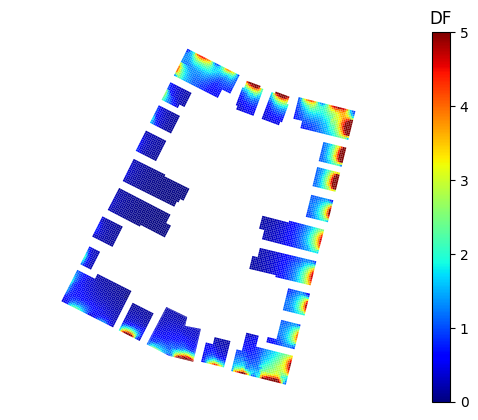

In [84]:
# Produce graphic
p = PatchCollection(patches, cmap=mpl.cm.jet, alpha=1)
p.set_array(flat_results)

fig, ax = plt.subplots()

ax.add_collection(p)
# autoscale to contents
ax.autoscale(True)
# fix aspect ratio
ax.axis('equal')
# turn off axes
ax.axis('off')
# Legend 
fig.colorbar(p).ax.set_title('DF')
p.set_clim([0,5])
fig.show()
plt.savefig("test.svg", bbox_inches='tight', dpi=500)
plt.savefig("test.png", bbox_inches='tight', dpi=500)
